Создано под руководством [статьи](https://docs.pymc.io/notebooks/probabilistic_matrix_factorization.html) из примеров PyMC3.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from IPython.display import clear_output
!pip install pymc3==3.9
import pymc3 as pm
if pm.__version__ == '3.9.0':
    clear_output()
    print('Ready to Bayes!')

Ready to Bayes!


# Задача

Обозначения:

$M$ - число фильмов (items)

$N$ - число пользователей (users)

$D$ - число скрытых (latent) признаков, описывающих каждый фильм

Матрицы:

$U$ - матрица $N \times D$ с признаковым описанием каждого фильма (ее строка - признаковое описание отдельного фильма)

$V$ - матрица $M \times D$ с описанием предпочтений пользователей (строка - как пользователь любит каждую из скрытых переменных)

$R$ (ratings) - матрица $N \times M$, где $R_{ij}$ - как пользователь $i$ любит фильм $j$

Мы наблюдаем матрицу $R$, причем не целиком (не все пользователи поставили свои рейтинги).$R_{ij}=U_i*V_j$ - скалярное произведение.

Задача - оценить матрицу $R=UV^T$. Обозначим ее оценку как $R^*$.

# Данные

In [ ]:
# user rating data
data = pd.read_csv(pm.get_data("ml_100k_u.data"), sep='\t',
                   names=["userid", "itemid", "rating", "timestamp"])
data.head()

,userid,itemid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
movie_columns  = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL',
                  'unknown','Action','Adventure', 'Animation',"Children's", 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv(
    pm.get_data("ml_100k_u.item"),
    sep="|",
    names=movie_columns,
    index_col="movie id",
    parse_dates=["release date"],
)
movies.head()

,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


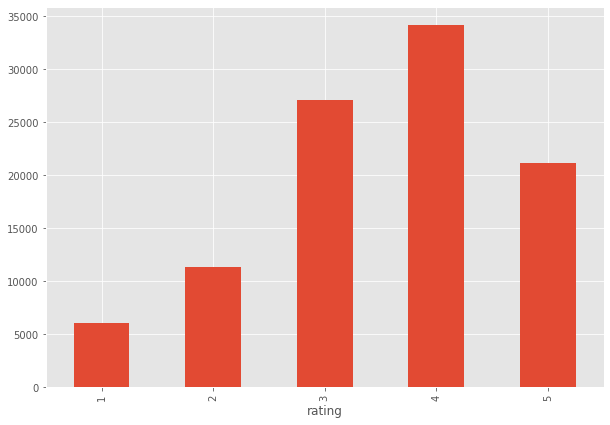

In [ ]:
ratings = data.rating
data.groupby('rating').size().plot(kind='bar', figsize=[10, 7]);

In [ ]:
data.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Теперь посмотрим на средние рейтинги по фильмам:

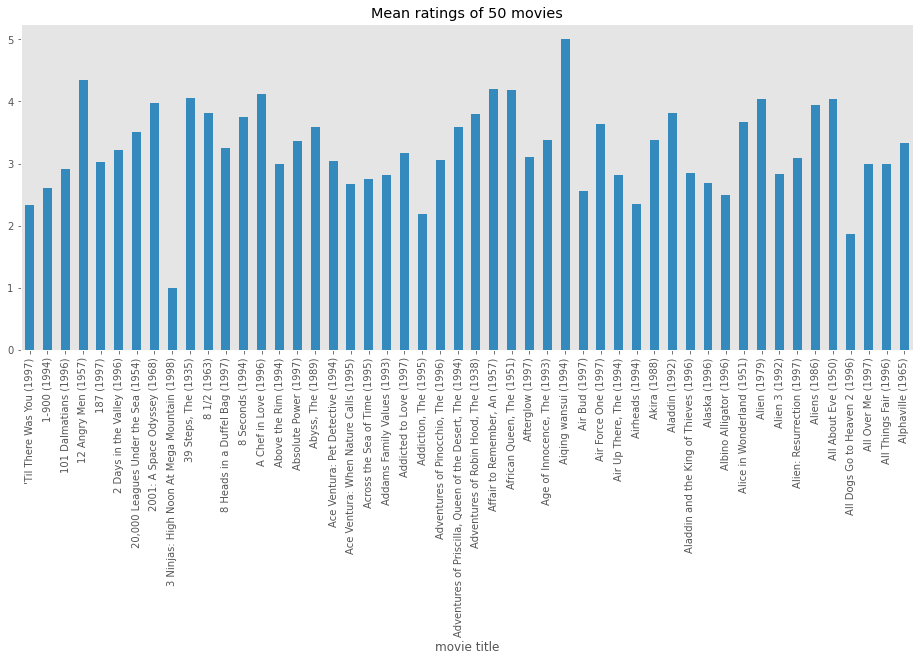

In [ ]:
movie_means = data.join(movies['movie title'], on='itemid').groupby('movie title').rating.mean()
movie_means[:50].plot(
    kind='bar',
    figsize = (16, 6),
    grid=False,
    title='Mean ratings of 50 movies',
    color='C1'
    );

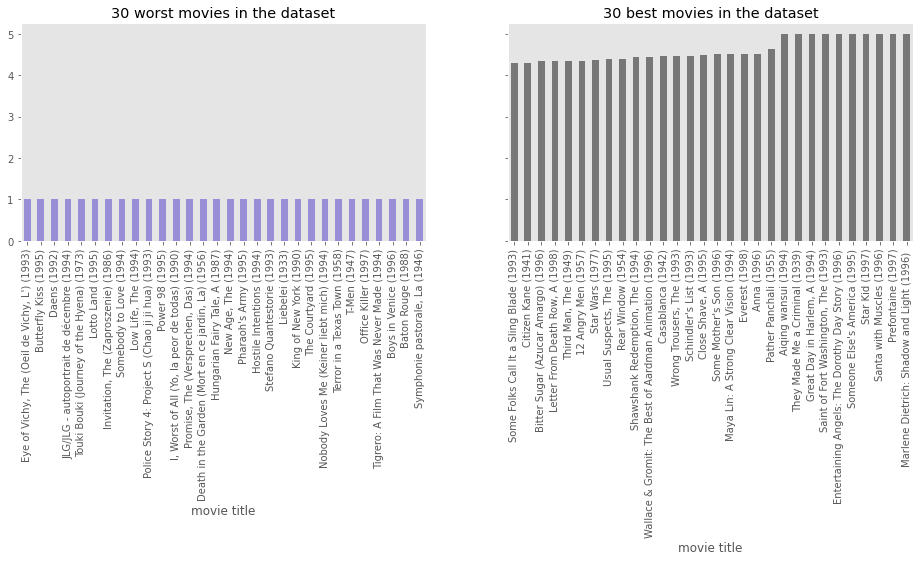

In [ ]:
# у большинства - средние рейтинги, посмотрим на худшие и лучшие фильмы
fig, ax = plt.subplots(1, 2, figsize=[16, 4], sharey=True)
kwargs = {
    'kind' : 'bar',
    'grid' : False,
}
movie_means.sort_values()[:30].plot(ax=ax[0],
                                    title='30 worst movies in the dataset',
                                    color='C2',
                                    **kwargs)
movie_means.sort_values()[-30:].plot(ax=ax[1],
                                     title='30 best movies in the dataset',
                                     color='C3',
                                     **kwargs);

In [ ]:
# итак, есть разница по оценкам среди фильмов, посмотрим на разницу среди пользователей
mean_ascending = data.groupby('userid').mean()['rating'].sort_values()
t = np.arange(len(mean_ascending)) + 1

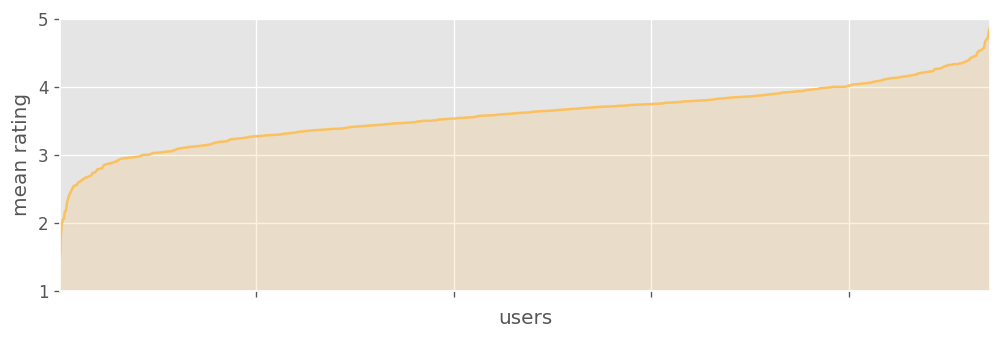

In [ ]:
fig, ax = plt.subplots(figsize=[10, 3], dpi=120)

ax.plot(t, mean_ascending, color='C4')
ax.fill_between(t, mean_ascending, alpha=0.2,  color='C4')
ax.set(xlabel='users', ylabel='mean rating', xlim=(1, 943), ylim=(1, 5),
       xticklabels='', yticks=np.arange(1, 6));

# Методы

# Baselines

In [ ]:
# небольшой костыль в метот __str__
def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append(''.join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append(''.join(tmp))
    return ' '.join(words)

split_title('HelloHowAreYou')

'Hello How Are You'

In [ ]:
# спасибо, 3 класс иада, что теперь я не боюсь классов
# попробуй потом str(...)
class Baseline:
    "Calculate baseline predictions."

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError("baseline prediction not implemented for base class")

    def rmse(self, test_data):
        return rmse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)

Дальше происходит небольшая магия с masked arrays, снизу простой пример:
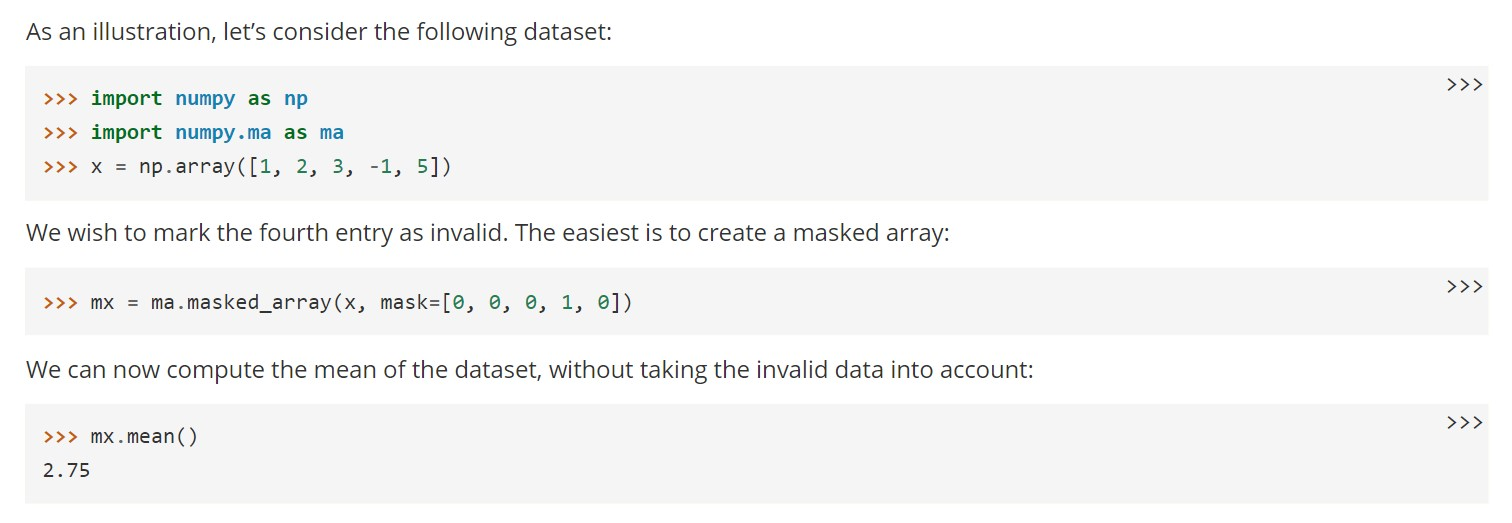

In [ ]:
class UniformRandomBaseline(Baseline):
    """Забиваем пропуски рандомом"""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()  # сколько всего пропущенных значений
        train_data[nan_mask] = np.random.uniform(pmin, pmax, N)
        self.predicted = train_data

In [ ]:
class GlobalMeanBaseline(Baseline):
    """Забиваем пропуски средним по всем рейтингам"""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data

In [ ]:
class MeanOfMeansBaseline(Baseline):
    """ 1/3 (средний рейтинг фильма + средний рейтинг пользователя + глобальный средний рейтинг)"""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        movie_means = masked_train.mean(0)
        user_means = masked_train.mean(1).reshape(-1, 1)
        global_mean = masked_train.mean()
        mean_substitutes = (movie_means + user_means + global_mean) / 3
        self.predicted = np.nan_to_num(train_data, copy=True, nan=0) + mean_substitutes * nan_mask

In [ ]:
UniformRandomBaseline?

In [ ]:
baseline_methods = {}
baseline_methods["ur"] = UniformRandomBaseline
baseline_methods["gm"] = GlobalMeanBaseline
baseline_methods["mom"] = MeanOfMeansBaseline

Матрица $R$ (c пропусками, потому что не каждый пользователь оценил каждый фильм):

In [ ]:
dense_data = data.pivot(index="userid", columns="itemid", values="rating")

In [ ]:
dense_data

itemid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dense_data = dense_data.values

## Probabilistic matrix factorization

Предположим, что элементы матриц $V$, $U$ имеют нормальное распределение с нулевым средним и *фиксированной* дисперсией, которую мы оценим как средний разброс по строкам и столбцам (возможно, не соответственно😂).

Затем получим оценку $R^*=\mathcal{N}(UV^T, \alpha)$, где $\alpha$ - также фиксирванный параметр (гиперпараметр), который отображает степень нашей неопределенности относительно оценки $R^*$.

Больше конкретики и формул в исходной статье :)


In [ ]:
import logging
import time
import scipy as sp  # пригодилось вообще ?)
import theano

In [ ]:
# забиваем на наличие промежуточных test values
theano.config.compute_test_value = "ignore"

# Set up logging. ШТА ?
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
class PMF:
    """Probabilistic matrix factorization model using PyMC3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """

        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # забиваем пропуски средним значением по всем не пустым ячейкам
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # priors для alpha_u, alpha_v построим на основе
        # средней дисперсии по строкам-столбцам матрицы
        self.alpha_u = 1 / self.data.var(1).mean()
        self.alpha_v = 1 / self.data.var(0).mean()

        # определяем модель
        # интересно, что параметры U, V фиксированы (т.е. не имеют распределений)
        with pm.Model() as pmf:
            U = pm.MvNormal(
                'U',
                mu=0,
                tau=self.alpha_u * np.eye(dim),
                shape=(n, dim),
                testval=np.random.randn(n, dim) * std
            )
            V = pm.MvNormal(
                'V',
                mu=0,
                tau=self.alpha_v * np.eye(dim),
                shape=(m, dim),
                testval=np.random.randn(m, dim) * std
            )
            R = pm.Normal(
                'R',
                (U @ V.T)[~nan_mask],
                tau=self.alpha,
                observed=self.data[~nan_mask]
            )

        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name

Будем использовать байесовскую модель двумя способами - просто предсказывать MAP, ну и по классике MCMC. Интересный факт:

---
*When the observation noise variance $\alpha$ and the prior variances $α_U$ and $α_V$ are all kept fixed, maximizing the log posterior is equivalent to minimizing the sum-of-squared-errors objective function with quadratic regularization terms.*

---

Короче просто ridge! (что особенно очевидно по формуле в статье)

In [ ]:
def _find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    t_start = time.time()
    with self.model:
        logging.info("finding PMF MAP using L-BFGS-B optimization...")
        self._map = pm.find_MAP(method='L-BFGS-B')

    elapsed = int(time.time() - t_start)
    logging.info(f"found PMF MAP in {elapsed} seconds")
    return self._map


def _map(self):
    try:
        return self._map
    except:
        return self.find_map()


# прокачиваем класс PMF
PMF.find_map = _find_map
PMF.map = property(_map)  # загадка на будущее, но вызывается как атрибут, а не метод

---
*So now our PMF class has a map property which will either be found using Powell optimization or loaded from a previous optimization.*

---

Далее функция для запуска MCMC:

In [ ]:
def _draw_samples(self, **kwargs):
    # если ключа 'chains' нет, он добавляется со значением 1
    # иначе ничего не меняется
    kwargs.setdefault('chains', 1)
    # интересный смысл одной цепочки: решение может быть не единственное
    # в лучшем случае - симметричное, в худшем - единственное с точностью до поворота 
    with self.model:
        self.trace = pm.sample(**kwargs)


PMF.draw_samples = _draw_samples

Наконец, функция для предсказаний. Для данных $U, V$ (из апостериорной выборки) вычисляем $R^*=UV^T$, которую используем для извлечения нормальной выборки в качестве среднего (precision $\alpha^2$ - мы задали в начале модели).

Теперь уже можно понять, почему это мера определенности 👍

In [ ]:
# будем использовать как для MAP, так и для сэмплов MCMC
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.random.normal(R, self.std)
    # поправка на ограниченность значений рейтингов
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict

# Evaluation

## Metrics

In [ ]:
# рабочая метрика - RMSE
# напишем ее самостоятельно для матриц с пропусками
def rmse(test_data, predicted):
    """ RMSE ignoring missing values in the test_data """  # почему пропуски в тестовых данных ? Просто особенность?
    # Идея в том, что матрица, на которой будем учиться, и так содержит дофига пропущенных значений
    # И только имеющиеся заполненные мы будем разбивать на train и test
    # У тестовой матрицы пропуски на местах пропусков в полной матрице + на местах трейна - их мы и не будем учитывать при подсчете RMSE

    I = ~np.isnan(test_data)
    N = I.sum()  # число непустых ячеек
    sqerror = (test_data - predicted) ** 2
    mse = sqerror[I].sum() / N
    return np.sqrt(mse)

In [ ]:
# также придется ручками написать train-test split
# я бы, наверное, написал бы по-другому, но сейчас
# постараюсь влезть в голову другого человека
def train_test_split(data, seed, persent_test=0.1):
    """
    Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """

    n, m = data.shape
    N = n * m  # cells in matrix


    train = data.copy()
    test = np.ones_like(data) * np.nan

    # список пар индексов, где в матрице нет пропусков
    tosample = np.where(~np.isnan(data))
    idx_pairs = list(zip(tosample[0], tosample[1]))

    test_size = int( len(idx_pairs) * persent_test )
    train_size = len(idx_pairs) - test_size

    indices = np.arange(len(idx_pairs))  # индексы пар индексов :)
    rng = np.random.RandomState(seed)
    sample = rng.choice(indices, size=test_size, replace=False)

    # в тест улетят только отсутствующие в трейне наблюдения, а не вся матрица ("внезапно")
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]
        train[idx_pair] = np.nan  # remove from train

    # проверим, что все прошло окей
    assert test_size == N - np.isnan(test).sum()
    assert train_size == N - np.isnan(train).sum()

    return train, test

In [ ]:
train, test = train_test_split(dense_data, seed=89)

## Results

In [ ]:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print(f"{method} RMSE:\t{baselines[name]:.5f}")

Uniform Random Baseline RMSE:	1.69910
Global Mean Baseline RMSE:	1.12093
Mean Of Means Baseline RMSE:	1.01094


Как и ожидалось, забивать рандомом оказалось хуже всего, а минимальное включение мозгов для улучшения второго метода тоже заметно отразилось на качестве.

Теперь попробуем PMF:

In [ ]:
alpha = 2  # => стандартное отклонение = 1 / 2

# число ненаблюдаемых признаков: при перемножении U @ V.T получается
# одинаковый результат вне зависимости от их числа. Поэтому их нужно выбрать как гиперпараметр
# Большее число => модель лучше подстраивается под данные (что может быть как + так и -)
# но в то же время возрастает и вычислительная сложность
# В конечном итоге у нас будет D * (M + N) ненаблюдаемых ПЕРЕМЕННЫХ
# то есть 10 * (943 + 1682) = 26250
dim = 10

pmf = PMF(train, dim=dim, alpha=alpha)

INFO:root:done building the PMF model


## Предсказание при помощи MAP

In [ ]:
# находим MAP
pmf.find_map()

INFO:root:finding PMF MAP using L-BFGS-B optimization...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


INFO:root:found PMF MAP in 103 seconds


{'U': array([[ 0.33182753,  0.83440181, -0.85978278, ..., -0.5084577 ,
          1.62390275, -0.40701529],
        [ 0.40519036,  0.67674399, -0.57511045, ...,  0.00909095,
          1.52506662, -0.46855797],
        [-0.08696554, -0.3221846 , -0.93956066, ..., -0.41797947,
          1.11162343, -0.34018735],
        ...,
        [ 0.36099909,  0.57652604, -1.04132573, ..., -0.11570079,
          1.38649567, -0.16247258],
        [ 0.66679185,  0.2550013 , -0.42220821, ..., -0.49762689,
          1.97707003, -0.4386571 ],
        [-0.85973519,  0.0549302 , -1.34784279, ...,  0.07146403,
          1.52580335, -0.37187068]]),
 'V': array([[ 0.12351352,  1.00417911, -1.10844565, ..., -0.27509412,
          1.59138661,  0.29567477],
        [ 0.19964004,  0.51133844, -0.67414518, ..., -0.45875517,
          1.28992055,  0.02397768],
        [ 0.11241274, -0.4161822 , -0.95319969, ..., -0.85317722,
          0.88990176, -0.9084898 ],
        ...,
        [ 0.03144193,  0.07928897, -0.233155

Протестируем теперь полученную оценку, не переобучилось ли и все такое:

In [ ]:
pmf.map

{'U': array([[ 0.44900543,  0.89395658,  1.06506778, ...,  0.27569794,
         -1.26188257,  0.35146509],
        [ 0.57666192,  0.1652932 ,  0.84652939, ..., -0.64412121,
         -1.10110157,  0.43507885],
        [ 0.49641749, -0.33500329,  0.34324913, ...,  0.51333163,
         -1.28449688,  0.29869585],
        ...,
        [ 0.47123662,  0.22699928,  0.58274902, ..., -0.34725686,
         -1.25694337,  0.14214361],
        [ 0.24374983, -0.37327587,  1.26290229, ..., -0.62113217,
         -1.31203542,  0.55502417],
        [ 0.49107511, -0.00448202,  1.01423457, ..., -0.98569123,
         -1.62777626, -0.68612386]]),
 'V': array([[ 0.91693155, -0.29510054,  0.90671628, ..., -0.22596341,
         -1.02895637, -0.04699094],
        [-0.04796623, -0.37887183,  1.11709987, ..., -0.323626  ,
         -0.89809363,  0.0843151 ],
        [ 0.30669697,  0.57656993,  0.27037986, ...,  0.24969578,
         -1.33378805,  0.30561494],
        ...,
        [ 0.18773265,  0.12959138,  0.005806

In [ ]:
# функция, которую затем пришьем к классу
def eval_map(pmf_model, train, test):
    U = pmf_model.map['U']
    V = pmf_model.map['V']

    # предсказываем R целиком, а затем проверяем
    # отдельно на трейновом и тестовом кусках 
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)

    # print report
    print(f'PMF MAP training rmse: {train_rmse:.5f}')
    print(f'PMF MAP testing rmse: {test_rmse:.5f}')
    print(f'Train/test difference: {test_rmse - train_rmse:.5f}')

    return test_rmse

PMF.eval_map = eval_map

In [ ]:
pmf_map_rmse = pmf.eval_map(train, test)
# improvement тут - на сколько упало
print(f"pmf map improvement: {(baselines['mom'] - pmf_map_rmse):.5f}")

PMF MAP training rmse: 1.01211
PMF MAP testing rmse: 1.14660
Train/test difference: 0.13449
pmf map improvement: -0.13566


Внезапно, качество модели наоборот упало! 

---
*This indicates that the point estimates for $α_U$ and $α_V$ that we calculated from our data are not doing a great job of controlling model complexity.*

---

Посмотрим, что с этим можно сделать, используя MCMC.

## Предсказание при помощи MCMC

In [ ]:
# spoiler alert: в конце окажется, что после 100 реализации rmse почти не падает
# не spoiler alert - ето доооолго :)
pmf.draw_samples(draws=100, tune=500, random_seed=89)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [V, U]
INFO:pymc3:NUTS: [V, U]


Sampling 1 chain for 500 tune and 100 draw iterations (500 + 100 draws total) took 5866 seconds.
INFO:pymc3:Sampling 1 chain for 500 tune and 100 draw iterations (500 + 100 draws total) took 5866 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# на случай внезапного падения сессии :)
np.save('/content/drive/MyDrive/Colab/Bayesian methods/U.npy', pmf.trace['U'])
np.save('/content/drive/MyDrive/Colab/Bayesian methods/V.npy', pmf.trace['V'])

In [ ]:
# костыль (элегантный костыль), изменяющий итерацию по словарю
# чтобы не переписывать функции, заточенные под trace object из pymc3
# класс настолько сырой, что даже не печатается - только самое необходимое :)
class trace_dict(dict):
    def __init__(self, dictionary):
        self.dict = dictionary
        self.keys = list(dictionary.keys())
        self.n_samples = self.dict[self.keys[0]].shape[0] - 1
        self.iter = 0


    def __iter__(self):
        return self


    def __next__(self):
        if self.iter == self.n_samples:
            # без обнуления (ммм...) счетчика получалась полная дичь
            self.iter = 0
            raise StopIteration
        else:
            to_be_returned = {name: self.dict[name][self.iter] for name in self.keys}
            self.iter += 1
            return to_be_returned

# заметка 07.02.21 - а тут не прокатит итерация с помощью dict.items? :)

In [ ]:
# backup с диска
U = np.load('/content/drive/MyDrive/Colab/Bayesian methods/U.npy')
V = np.load('/content/drive/MyDrive/Colab/Bayesian methods/V.npy')
pmf.trace = trace_dict({'U' : U, 'V' : V})
del U, V

### Diagnostics and posterior predictive check

Обычно можно просто посмотреть traceplot и прикинуть, когда цепь начала сходиться, а предыдущие реализации выкинуть. Но в нашем случае реализации цепи - это матрицы.

Будем смотреть на *норму Фробениуса* матрицы - корень из суммы квадратов ее элементов (аналогично Евклидовой норме).

In [ ]:
def _norms(pmf_model, monitor=('U', 'V'), ord='fro'):
     """Return norms of latent variables at each step 
     in the sample trace."""
     norms = {var: [] for var in monitor}
     for sample in pmf_model.trace:
         for var in monitor:
             norms[var].append(np.linalg.norm(sample[var], ord)) 
     return norms


def _traceplot(pmf_model):
     """Plot Frobenius norms of U and V as a function of sample #."""
     trace_norms = pmf_model.norms()
     u_series = pd.Series(trace_norms['U'])
     v_series = pd.Series(trace_norms['V'])
     fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
     u_series.plot(kind='line', ax=ax1, color='C1',
                   grid=False, title=r"$\|U\|_{Fro}^2$ at Each Sample")
     v_series.plot(kind='line', ax=ax2, color='C2',
                   grid=False, title=r"$\|V\|_{Fro}^2$ at Each Sample")
     ax1.set(xlabel='sample number')
     ax2.set(xlabel='sample number')


PMF.norms = _norms
PMF.traceplot = _traceplot

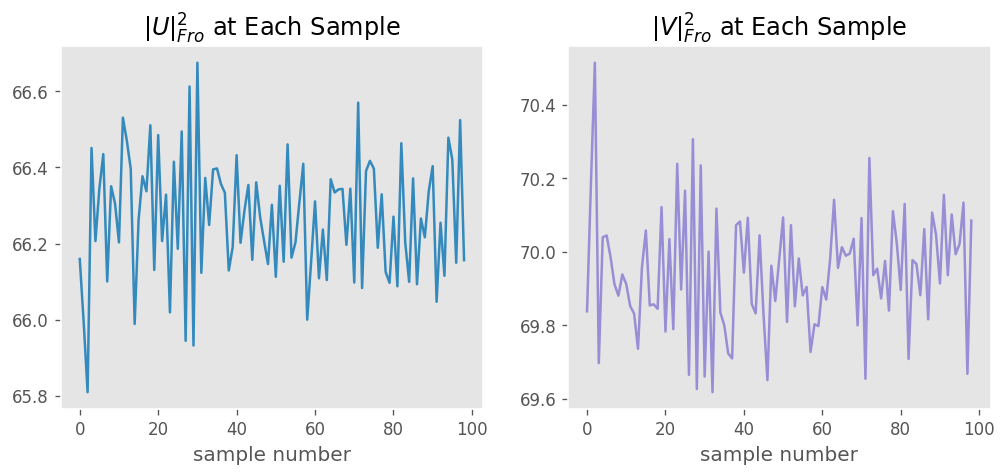

In [ ]:
pmf.traceplot()

Видимо, норма сошлась уже после дефолтного тьюнинга (500 реализаций) - это легче видеть на картинке из статьи с 500 сэмплами после тьюнинга.

Теперь посмотрим на RMSE в зависимости от номера шага алгоритма:

In [ ]:
# теперь посмотрим на ошибку на каждом каждой выборке и по накопленному среднему
def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence."""
    results = {'per-step-train' : [], 'running-train' : [],
               'per-step-test' : [], 'running-test' : []}
    R = np.zeros_like(test_data)

    for j, sample in enumerate(pmf_model.trace):
        sample_R = pmf_model.predict(sample['U'], sample['V'])
        R += sample_R
        # усредненная по всем предыдущим предсказаниям оценка R
        running_R = R / (j + 1)
        results['per-step-train'].append(rmse(train_data, sample_R))
        results['running-train'].append(rmse(train_data, running_R))
        results['per-step-test'].append(rmse(test_data, sample_R))
        results['running-test'].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(kind='line', grid=False, figsize=(15, 7),
                     title="Per-step and Running RMSE From Posterior Predictive")
    
    # итоговая оценка R и все промежуточные результаты
    return running_R, results


PMF.running_rmse = _running_rmse

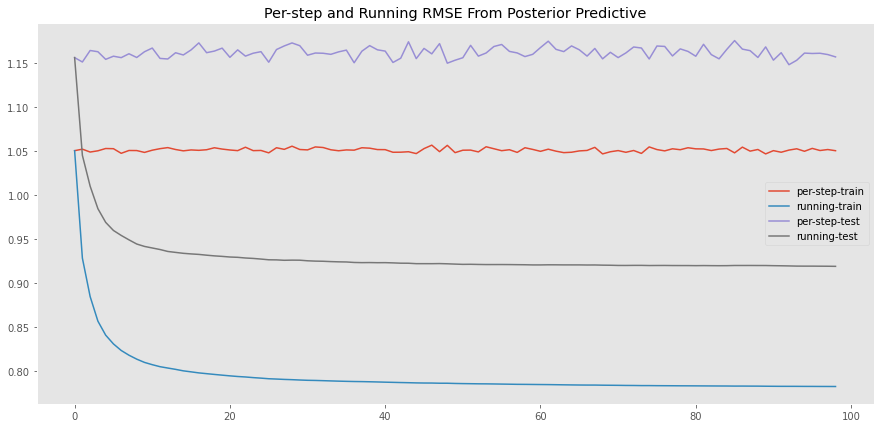

In [ ]:
predicted, results = pmf.running_rmse(test, train)

In [ ]:
# final rmse
final_test_rmse = results['running-test'].values[-1]
final_train_rmse = results['running-train'].values[-1]
print(f'Posterior predictive train RMSE: {final_train_rmse:.5f}')
print(f'Posterior predictive test RMSE: {final_test_rmse:.5f}')
print(f'Train/test difference: {final_test_rmse - final_train_rmse:.5f}')
print(f'Improvement from MAP: {pmf_map_rmse - final_test_rmse:.5f}')
print(f'Improvement from mean of means: {baselines["mom"] - final_test_rmse:.5f}')

Posterior predictive train RMSE: 0.78278
Posterior predictive test RMSE: 0.91901
Train/test difference: 0.13622
Improvement from MAP: 0.22759
Improvement from mean of means: 0.09193


## Summary of results

In [ ]:
all_results = {
    'global means' : baselines['gm'],
    'mean of means' : baselines['mom'],
    'uniform random' : baselines['ur'],
    'PMF MAP' : pmf_map_rmse,
    'PMF MCMC' : final_test_rmse
}

all_results = pd.Series(all_results).sort_values()

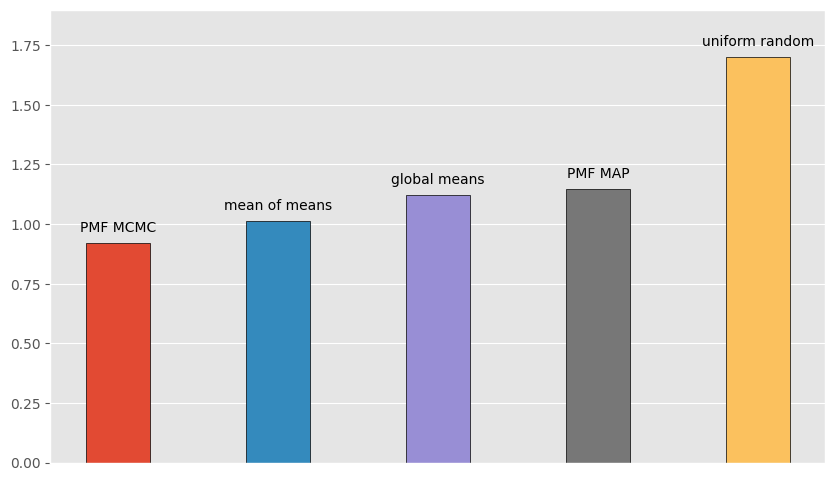

In [ ]:
plt.figure(dpi=100, figsize=[10, 6])

plt.bar(x=np.arange(5),
        height=all_results,
        width=0.4,
        color=['C' + str(j) for j in range(5)],
        ec='k')

for j in range(5):
    plt.text(j, all_results.iloc[j] + 0.05, all_results.index[j], ha='center')

plt.ylim(0, 1.9)
plt.xticks([]);

# Takeaway

Модель: 

 - моя первая модель со скрытыми переменными и разложением матриц :)
 - число скрытых переменных - гиперпараметр
 - норма Фробениуса - один из способов мониторить сходимость марковской цепи для матриц
 - предпоследняя картинка - чудо некоррелированных моделей

Код:
 - получилось реализовать целый класс PMF с большим количеством методов (см. ниже)
 - некоторые методы вызывают другие внутри себя для удобства применения
 - костыль-класс для особой итерации по словарю
 - писать docstring - это полезно
 - впервые в боевой задаче применил pivot table из pandas
 - `dictionary.setdefault(key, value)` для словарей
 - `np.ma.masked_array`
 - метод `.plot()` для `pd.Series` и `pd.DataFrame` - юзабельная штука
 - logging (хотя и непонятно, почему нельзя просто печатать сообщения)

In [ ]:
dir(PMF)[-8:]

['draw_samples',
 'eval_map',
 'find_map',
 'map',
 'norms',
 'predict',
 'running_rmse',
 'traceplot']